# GALFIT wrapper

In [83]:
import numpy as np
from frb.galaxies import galfit as glf
from matplotlib import pyplot as plt
import os

from astropy.io import fits
from astropy.wcs import WCS
from astropy import visualization as vis
from astropy.table import Table
from astropy.stats import sigma_clipped_stats

from importlib import reload

In [38]:
plt.rcParams['font.size'] = 17

In [89]:
reload(glf)

<module 'frb.galaxies.galfit' from '/home/sunil/Python/FRB/frb/galaxies/galfit.py'>

## Running GALFIT
GALFIT is a 2D morphology modeling software that fits light distribution models to imaging data. It requires two key files to run: and image fits file and a PSF fits file. The PSF file can be generated usign your favourite method. In the example shown below, it was create using `photutils`' ePSF methods.

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/home/sunil/anaconda3/lib/python3.7/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/sunil/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/sunil/anaconda3/lib/python3.7/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/sunil/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


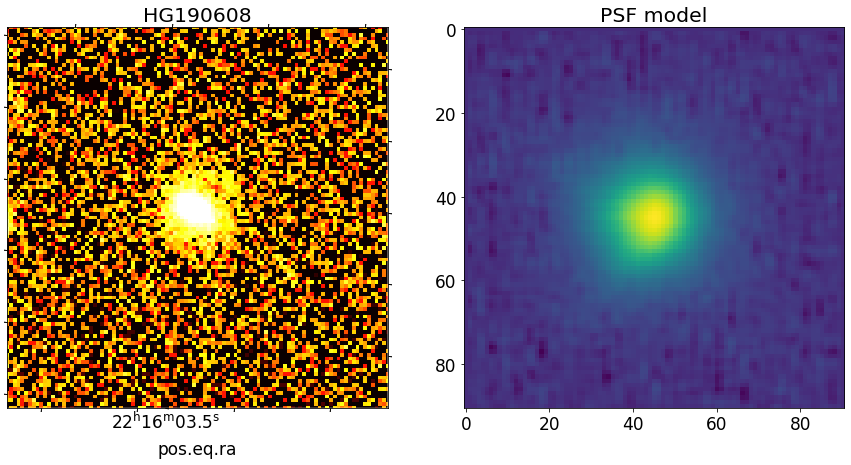

In [31]:
# Example image and PSF files
imgfile = "/home/sunil/Desktop/FRB/190608/GALFIT/frame-i-001659-5-0192.fits"
psffile = "/home/sunil/Desktop/FRB/190608/GALFIT/avg_SDSS_psf_I.fits"

region = (635, 735, 967, 1067) # Region in the img to be fit (xmin, xmax, ymin, ymax)

img, hdr = fits.getdata(imgfile, header=True)
psf, psfhdr = fits.getdata(psffile, header=True)

fig = plt.figure(figsize=(15, 7))
imgmean, imgmed, imgstd = sigma_clipped_stats(img)
ax = plt.subplot(121, projection=WCS(hdr))
lon = ax.coords[0]
lat = ax.coords[1]

lon.set_ticks(number=5)
ax.imshow(img, norm = vis.ImageNormalize(stretch=vis.LogStretch()),
          vmin = imgmed, vmax = 10*imgstd + imgmed, cmap = "hot")
ax.set_title("HG190608")
ax.set_xlim(region[0], region[1])
ax.set_ylim(region[2], region[3])

ax = plt.subplot(122)
psfmean, psfmed, psfstd = sigma_clipped_stats(psf)
ax.imshow(psf, norm = vis.ImageNormalize(stretch=vis.LogStretch()))
ax.set_title("PSF model")
plt.show()

In [6]:
help(glf.run)

Help on function run in module frb.galaxies.galfit:

run(imgfile, psffile, **kwargs)
    Run galfit. 
    
    Args:
        imgfile (str): path to the image fits file.
        psffile (str): path to the PSF model fits file.
    
    Valid kwargs:
    
        configfile (str, optional): path to configuration file to
            be created via this function.
        outfile (str, optional): path to GALFIT's output fits file.
            Defaults to `out.fits`
        finesample (int, optional): The PSF fine-sampling factor.
            Assumes no fine-sampling (i.e. a factor of 1) by default.
        badpix (str, optional): File containing a list of bad pixels.
            Assumes all pixels a re fine by default.
        constraints (str, optional): File containing fit parameter
            bounds. Check out this example constraints file
            https://users.obs.carnegiescience.edu/peng/work/galfit/EXAMPLE.CONSTRAINTS
            to learn how to use one.
        region (tuple, opt

In [90]:
# run GALFIT using the wrapper
imgfile = "/home/sunil/Desktop/FRB/190608/GALFIT/frame-i-001659-5-0192.fits"
psffile = "/home/sunil/Desktop/FRB/190608/GALFIT/avg_SDSS_psf_I.fits"
outdir = "/home/sunil/Desktop/galfit_out"

# Define fit parameters
region = (635, 735, 967, 1067) # Region in the img to be fit (xmin, xmax, ymin, ymax)
platescale = 0.0355 # arcsec/pix
finesample = 3 # PSF oversampling factor
position = (685, 1017) # Guess for centroid location in pix (x, y)

# Returns 0 when the run is successful
glf.run(imgfile, psffile, outdir = outdir,
        finesample = finesample, region = region,
        platescale = platescale, position = position,
        int_mag = 19.4, r_e = 5, n = 1.0, axis_ratio = 0.5,
        pa = 0)

/home/sunil/Python/FRB/frb/galaxies/galfit.py:97: UserWarning: Creating a configuration file here
  
/home/sunil/Python/FRB/frb/galaxies/galfit.py:108: UserWarning: Creating output file here
  fstream.write("B) {:s}  # Output data image block\n".format(os.path.join(outdir,outfile)))
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


0

## Reading in the output

In [91]:
outfile = os.path.join(outdir, "out.fits")
hdulist = fits.open(outfile)
hdulist.info()

Filename: /home/sunil/Desktop/galfit_out/out.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (101, 101)   float32   
  1                1 ImageHDU        87   (101, 101)   float32   
  2                1 ImageHDU        45   (101, 101)   float32   
  3                1 ImageHDU         8   (101, 101)   float32   
  4  FITPARAMS     1 BinTableHDU     37   1R x 14C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [92]:
# Fit parameters
Table(hdulist['FITPARAMS'].data)

ra,ra_err,dec,dec_err,mag,mag_err,reff_ang,reff_ang_err,n,n_err,b/a,b/a_err,PA,PA_err
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
334.0204233223128,0.0028399999999999996,-7.898845810463966,0.0024850000000000002,24.01,0.03,0.11998999999999999,0.009585,3.78,0.69,0.76,0.06,54.22,8.37


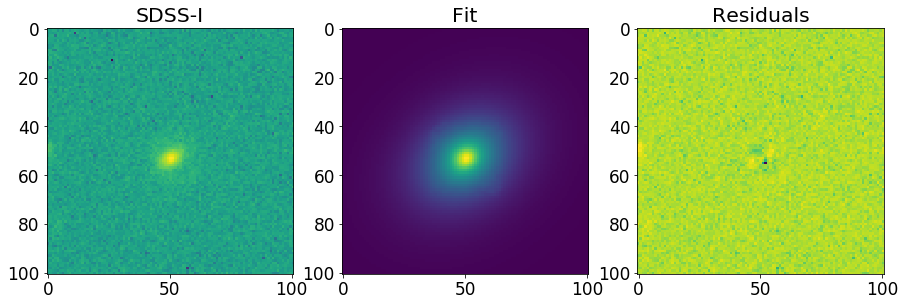

In [95]:
# output images
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
labels = ['SDSS-I','Fit','Residuals']
for hdu,ax,label in zip(hdulist[1:4],axs,labels):
    ax.imshow(hdu.data, norm=vis.ImageNormalize(stretch=vis.LogStretch()))
    ax.set_title(label)